# Diabetic Retinopathy Project

### This project is part of the classwork for The Machine learning Course (SBE3021), Faculty of Engineering, Cairo University.
### Under supervision of Dr: Inas Yassine and Eng. Merna Bebars

#### Contributors:
#### * Aya Sameh
#### * Ehab Kamal
#### * Hanya Ahmad
#### * Mohamed Hashem 


### Diabetic retinopathy is a common complication of diabetes and a leading cause of vision loss in adults. It occurs when high blood sugar levels damage the blood vessels in the retina, leading to vision impairment and even blindness if left untreated. Early detection is crucial for managing the progression of this disease.



### In this project, we aim to develop a model that can accurately detect diabetic retinopathy using a dataset of fundus images. We will employ different image processing techniques to extract features from  retina images that will be used with a classifier to predict the disease.

## 1. introduction and data exploration 

In [106]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import os
import cv2 as cv
from sklearn.metrics import confusion_matrix,  precision_recall_curve


In [84]:
%%HTML

<style>
td,th {
  font-size: 18px
}
</style>
<table style="float: left;">

</table>

### 1.1 Dataset descripton 

#### we have used a data set of 758 Fundus color images that were acquired at the Department of Ophthalmology of the Hospital de Clínicas, Facultad de Ciencias Médicas,Paraguay. the images were obtained using a Visucam 500 cmaera of the zeis brand.

#### the data is categorized as 7 classes but we have merged the similar classes together to get only 3 classes because our classification problem is not concerned with the severity rather than the detection. the data quantization can be seen in the following table. 





<font size="8">
  


| Class  | Quantity |
| ------ | -------- |
| No DR  | 187      |
| NPDR   | 368      |
| PDR    | 202      |

</font>

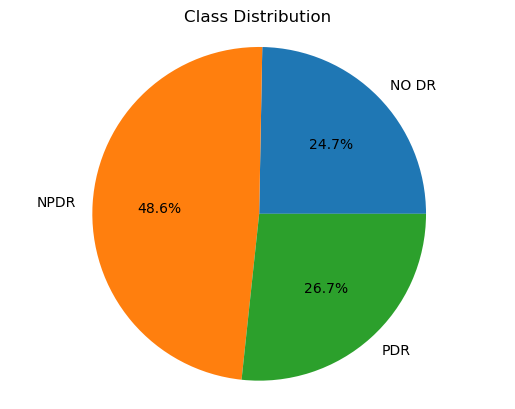

In [85]:
# Class distribution
class_labels = ['NO DR', 'NPDR', 'PDR']
class_counts = [187, 368, 202]

# Create the pie chart
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%')

# Set aspect ratio to be equal so that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('Class Distribution')

# Display the pie chart
plt.show()

### 1.2 Sample images visualization 

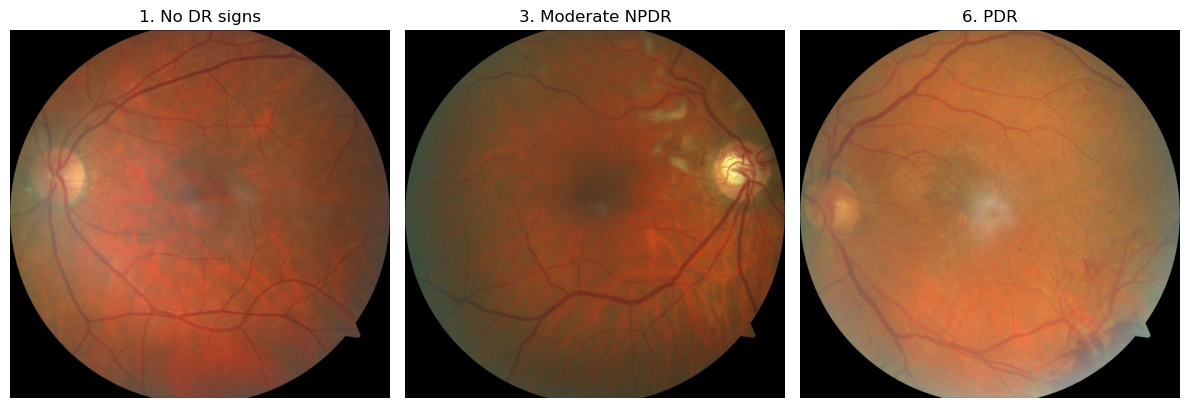

In [86]:
import os
from PIL import Image

# Set the folder paths 

folder1_path = "./dataset/Normal"
folder2_path = "./dataset/NPDR"
folder3_path = "./dataset/PDR"
# Set the number of rows and columns for subplots
num_rows = 1
num_cols = 3

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4))

# Iterate over the folders and plot images
for i, folder_path in enumerate([folder1_path, folder2_path, folder3_path]):
    # Get the image file paths from the folder
    image_files = os.listdir(folder_path)
    
    # Select the first image from the folder
    image_path = os.path.join(folder_path, image_files[0])
    
    # Load and plot the image
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(folder_path.split('\\')[-1])
    
# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()



### 1.3 image resolution and color channels



(2056, 2124, 3)


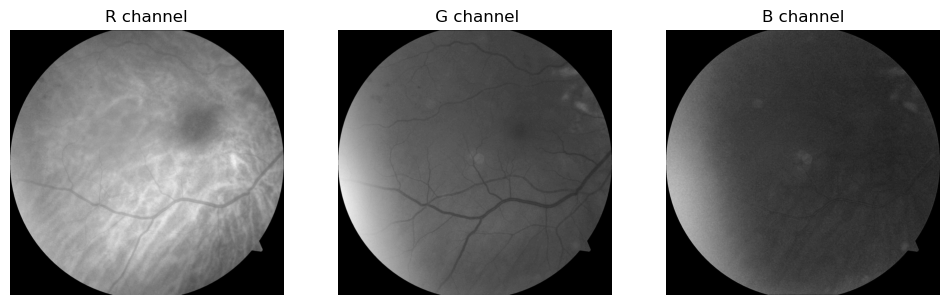

In [87]:
num_rows = 1
num_cols = 3

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4))
image_files = os.listdir(folder2_path)
    
# Select the sixth image from the folder
image_path = os.path.join(folder2_path, image_files[5])
    
# Load and plot the image channels and  print its resolution
image = Image.open(image_path)
image = np.array(image)

axes[0].imshow(image[:,:,0],cmap='gray')
axes[0].axis('off')
axes[0].set_title("R channel")
axes[1].imshow(image[:,:,1],cmap='gray')
axes[1].axis('off')
axes[1].set_title(" G channel")
axes[2].imshow(image[:,:,2],cmap='gray')
axes[2].axis('off')
axes[2].set_title("B channel")
print(image.shape)


#### Our images are of high resolution (2056,2124)  with 3 color channels, so we might need to resize them to reduce the computational complexity, we also notice that the green channel holds the greatest contrast to blood vessels in the image.
#### in the next section we will explore the pre processing steps that we are going to use to prepare the data for feature extraction and the machine learning model.

## 2. Pre-Processing 

### DR is medically known to cause some distinct features to the retinas of the patients including: abnormality of retinal blood vessels, microaneurysms, and hard exudates among others. after examining several research paper that use a traditional machine learning approach we choose to extract :-
#### - blood vessels.
#### -microaneurysms.
#### -hard exudates 



### 2.1 helper methods
#### we will define a few methods to help us in our pre-processing.


In [24]:
def convert_to_grayscale_dot_product(image):
    # Perform dot product for grayscale conversion
    grayscale_img = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

    return grayscale_img

In [23]:
def green_ch_extract(image):
    green_ch=image[:,:,1]
    return green_ch
    

In [90]:
import cv2 as cv

def resize_image(image, width, height):

  resized_image = cv.resize( image,(width, height))

  return resized_image


### 2.2  CLAHE : Contrast Limited Adaptive Histogram Equalization is a typical method in diabetic retinopathy detection to improve the contrast which helps us to see the blood vessels more clearly.

In [26]:
def create_clahe(img):
        clahe = cv.createCLAHE(clipLimit=15.0, tileGridSize=(8,8))
        cl1 = clahe.apply(img)
        return cl1
    

Text(0.5, 1.0, 'green channel Image')

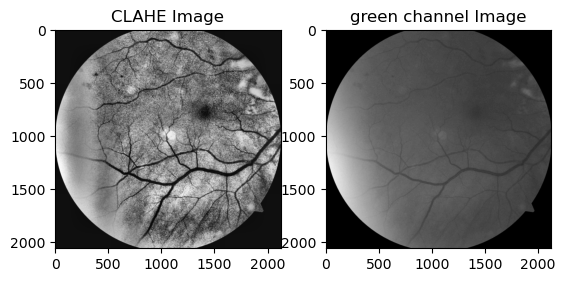

In [92]:
### visualize clahe and normal channel img
cl=create_clahe(image[:,:,1])
plt.subplot(1,2,1)
plt.imshow(cl,cmap='gray')
plt.title("CLAHE Image")
plt.subplot(1,2,2)
plt.imshow(image[:,:,1],cmap='gray')
plt.title("green channel Image")

### 2.3 Blood vessel detection: 
#### the process of blood vessel detection includes mainly five steps. 
##### 1. Apply CLAHE to the image to improve the contrast.
##### 2. Apply a morphological opening operation to remove small dark objects from the image.
##### 3. Apply a morphological closing operation to remove small bright objects from the image.
##### 4. Threshold the image to binarize it.
##### 5. subtract the image from the morphological operation image to get the blood vessel ( top hat operation )

#### for more info check : http://helix.dnares.in/wp-content/uploads/2018/09/3932-3937.pdf and https://github.com/aravind-3105/Retinal-Blood-Vessels-Segmentation-and-Denoising/tree/main



In [21]:
def blood_vessels_detection(img):
    gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    green_channel=green_ch_extract(img)
    cl1=create_clahe(gray_image)
    kernel =  cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
    opening = cv.morphologyEx(green_channel, cv.MORPH_OPEN, kernel)
    blur = cv.blur(opening,(5,5))
    cl2 = create_clahe(green_channel)
    img12= cv.subtract(cl2, blur)
    blur = cv.blur(img12,(5,5))
    ret,thresh1 = cv.threshold(blur,3,255,cv.THRESH_BINARY)
    erosion = cv.erode(thresh1,kernel,iterations = 2)
    vessels_img=cv.bitwise_not(erosion)
    return vessels_img

(-0.5, 699.5, 604.5, -0.5)

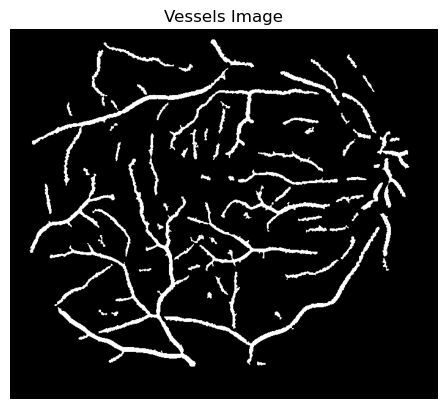

In [114]:
image=Image.open("./sample/17_right.jpeg")
image=np.array(image)
blood_vessels = blood_vessels_detection(image)
plt.imshow(blood_vessels,cmap='gray')
plt.title("Vessels Image")
plt.axis('off')


#### we obtained fairly reasonable results for using clahe and morphological operations for blood vessels extraction, the next step is detecting microaneurysms.


### 2.4 microaneurysms detection : microaneurysms appear as small unique patterns in a circular shape around the blood vessels. the steps to detect them are:-
#### - extract green channel 
#### - morphologica opening with a disk element 
#### -invert the image


In [19]:
import skimage.morphology as skm

def microaneurysm_detection(img):
    green_channel =green_ch_extract(img)
    kernel = skm.disk(5, np.uint8)
    opening = cv.morphologyEx(green_channel, cv.MORPH_OPEN, kernel, iterations=1)
    opening_2 = cv.morphologyEx(opening, cv.MORPH_OPEN, kernel, iterations=2)
    microaneurysm_img = cv.adaptiveThreshold(opening_2, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 35, 3)
    return microaneurysm_img

(-0.5, 3887.5, 2591.5, -0.5)

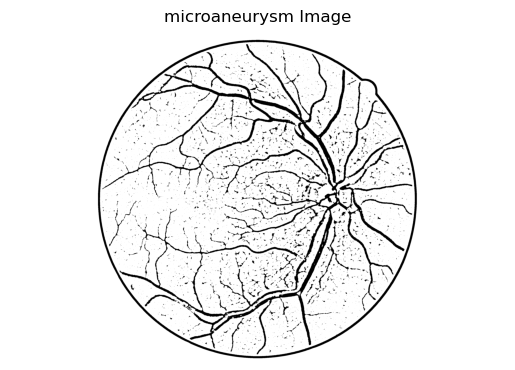

In [116]:
image=Image.open("./sample/17_right.jpeg")
image=np.array(image)
micro_aner = microaneurysm_detection(image)
plt.imshow(micro_aner,cmap='gray')
plt.title("microaneurysm Image")
plt.axis('off')

### 2.5 Exudates detection: exudates are small, bright spots on the retina caused by the leakage of fluid from blood vessels. the steps of detection include:- 
#### - green channel extraction
#### - Histogram equalization 
#### - inversion and thresholding 

In [18]:
def exudates_detection(img):
    green_channel = green_ch_extract(img)
    equalized_img = create_clahe(green_channel)
    # inv_blur = cv.blur(inv_equalized,(5,5))
    ret,thresh = cv.threshold(equalized_img,4,255,cv.THRESH_BINARY)
    exudates_img= cv.bitwise_not(thresh)

    return exudates_img

(-0.5, 2591.5, 1943.5, -0.5)

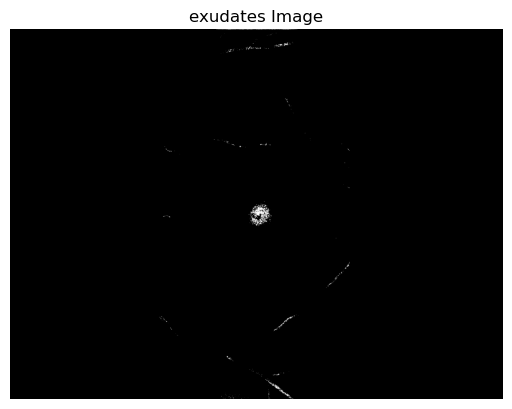

In [120]:
image=Image.open("./sample/13_left.jpeg")
image=np.array(image)
exudates = exudates_detection(image)
plt.imshow(exudates ,cmap='gray')
plt.title("exudates Image")
plt.axis('off')

#### we notice the small bright spot in the center of the image and with this step we conclude our 3 main steps of pre-processing with detecting blood vessels , exudates, and microaneurysms. we will combine the detection process in one function that we can use later after we build our data set to feed the feature extraction process.

In [17]:
def abnormality_detection(img):
    blood_vessels = blood_vessels_detection(img)
    microaneurysm = microaneurysm_detection(img)
    exudates = exudates_detection(img)
    return blood_vessels, microaneurysm, exudates

(-0.5, 3887.5, 2591.5, -0.5)

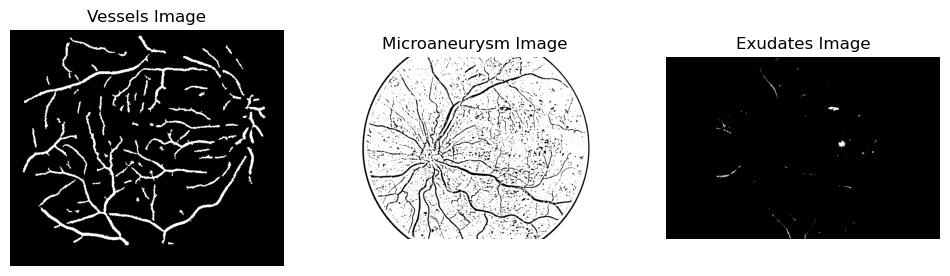

In [128]:
image=Image.open("./sample/16_right.jpeg")
image=np.array(image)
vessels_img,microaneurysm_img, exudates_img = abnormality_detection(image)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(vessels_img,cmap='gray')
plt.axis('off')
plt.title("Vessels Image")
plt.subplot(1,3,2)
plt.imshow(microaneurysm_img,cmap='gray')
plt.title("Microaneurysm Image")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(exudates_img,cmap='gray')
plt.title("Exudates Image")
plt.axis('off')

### 3. Feature Extraction : We have opted to extract the GLCM features from the preprocessed images, GLCM stands for Gray Level Co-occurrence Matrix. It is a statistical method that is used to analyze the spatial relationships between neighboring pixels in an image.

#### It is typically used to extract texture features of images, which is highly relevant in analyzing image to detect abnormalities,  the features include :-
#### - Contrast : the sum of the squared differences between all pairs of adjacent pixels in the image.
#### - Energy: the sum of the squares of all the elements in the GLCM.
#### - Homogeneity: the sum of the probabilities of all pairs of adjacent pixels having the same gray level value.
#### - Correlation: the Pearson correlation coefficient between all pairs of adjacent pixels in the image.




In [34]:
def feature_extraction(vessels_img, microaneurysm_img, exudates_img ):
    imgs = [vessels_img, microaneurysm_img, exudates_img]
    features=[]
    for img in imgs:
        distances = [1]  # Specify the distances for pixel pairs
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Specify the angles for pixel pairs
        glcm = skimage.feature.graycomatrix(img, distances, angles, symmetric=True, normed=True)
        energy = skimage.feature.graycoprops(glcm, prop="energy")
        contrast = skimage.feature.graycoprops(glcm, prop="contrast")
        homogeneity = skimage.feature.graycoprops(glcm, prop="homogeneity")
        correlation = skimage.feature.graycoprops(glcm, prop="correlation")
        curr_features=[energy,contrast,homogeneity,correlation]
        features.append(curr_features)
    # List of three lists each list has four arrays each having four values
    return features

### 4. Data set build : We later found the need to reduce our classes to binary classes to improve the accuracy of our detection, so we defined a function to consturct the data set in a multi class type and a binary type by combining the NPDR and PDR classes together, We use the GLCM features for every image as mentioned before.

In [89]:
def construct_dataset(binary = False):
    normal_path = "./dataset/Normal"
    npdr_path = "./dataset/NPDR"
    pdr_path = "./dataset/PDR"
    # Initialize the lists to store the features and labels
    features_list = []
    labels_list = []
    # Loop through the images in each folder and extract the features
    for folder_path, folder_name in [(normal_path, "Normal"), (npdr_path, "NPDR"), (pdr_path, "PDR")]:
        for file_name in os.listdir(folder_path):
            # Read the image using cv.imread()
            img = cv.imread(os.path.join(folder_path, file_name))
            # img = cv.resize(img,(500,500))
            if(binary):
                if (folder_name != 'Normal'):
                    folder_name = 'DR'
            # Call the abnormality_detection() function to get the abnormality images
            vessels_img, microaneurysm_img, exudates_img = abnormality_detection(img)
            # Call the feature_extraction() function to get the features
            features = feature_extraction(vessels_img, microaneurysm_img, exudates_img)
            features = np.array(features).reshape(-1)
            # Append the features and corresponding label to the lists
            features_list.append(features)
            labels_list.append(folder_name)
            
    # Convert the features and labels to NumPy arrays
    features_array = np.array(features_list)
    labels_array = np.array(labels_list)
    return features_array,labels_array

In [90]:

features_array,labels_array = construct_dataset()
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=0, stratify=labels_array)


## 5. Grid search for model & hyperparameters selection

In [91]:
def find_best_clf():
    classifiers = [
    DecisionTreeClassifier(),
   
     RandomForestClassifier()
    ]

    # Set up the hyperparameter grids for each classifier
    dt_param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 15]
    }

    rf_param_grid = {
        'n_estimators': [50, 100,200],
        'max_depth': [5, 10, 15]
    }

    param_grids = [dt_param_grid, rf_param_grid]

    # Set up the GridSearchCV object to find the best classifier
    best_clf = None
    best_score = 0
    
    for i, clf in enumerate(classifiers):
        grid_search = GridSearchCV(clf, param_grids[i], cv=5)
        grid_search.fit(X_train, y_train)
        score = grid_search.score(X_test, y_test)
        print("Classifier:", clf.__class__.__name__)
        print("Best parameters:", grid_search.best_params_)
        print("Accuracy:", score)
        print()
        if score > best_score:
            best_clf = grid_search.best_estimator_
            best_score = score


    print("Best classifier:", best_clf.__class__.__name__)
    return best_clf

In [92]:
find_best_clf()

Classifier: DecisionTreeClassifier
Best parameters: {'criterion': 'entropy', 'max_depth': 5}
Accuracy: 0.6973684210526315

Classifier: RandomForestClassifier
Best parameters: {'max_depth': 10, 'n_estimators': 50}
Accuracy: 0.6973684210526315

Best classifier: DecisionTreeClassifier


DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [93]:
clf = RandomForestClassifier(n_estimators=50,max_depth=15) 
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.7039473684210527


### Binary Classification


In [94]:

features_array_bin,labels_array_bin = construct_dataset(binary=True)



In [95]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(features_array_bin, labels_array_bin, test_size=0.2, random_state=0,stratify=labels_array_bin)

In [96]:
def find_best_clf_bin():
    classifiers = [
    DecisionTreeClassifier(),
     RandomForestClassifier()
    ]

    # Set up the hyperparameter grids for each classifier
    dt_param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 15]
    }

    rf_param_grid = {
        'n_estimators': [50, 100,200],
        'max_depth': [5, 10, 15]
    }

    param_grids = [dt_param_grid, rf_param_grid]

    # Set up the GridSearchCV object to find the best classifier
    best_clf = None
    best_score = 0
    
    for i, clf in enumerate(classifiers):
        grid_search = GridSearchCV(clf, param_grids[i], cv=5)
        grid_search.fit(X_train_bin, y_train_bin)
        score = grid_search.score(X_test_bin, y_test_bin)
        print("Classifier:", clf.__class__.__name__)
        print("Best parameters:", grid_search.best_params_)
        print("Accuracy:", score)
        print()
        if score > best_score:
            best_clf = grid_search.best_estimator_
            best_score = score


    print("Best binary classifier:", best_clf.__class__.__name__)
    return best_clf

In [97]:
find_best_clf_bin()

Classifier: DecisionTreeClassifier
Best parameters: {'criterion': 'gini', 'max_depth': 5}
Accuracy: 0.8223684210526315

Classifier: RandomForestClassifier
Best parameters: {'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.8881578947368421

Best binary classifier: RandomForestClassifier


RandomForestClassifier(max_depth=5)

In [98]:
clf_bin = RandomForestClassifier(n_estimators=50,max_depth=10) 
clf_bin.fit(X_train_bin, y_train_bin)
accuracy = clf_bin.score(X_test_bin, y_test_bin)
print("Accuracy: ", accuracy)


Accuracy:  0.8881578947368421


## 6. Performance metrics

### 6.1 Confusion Matrix

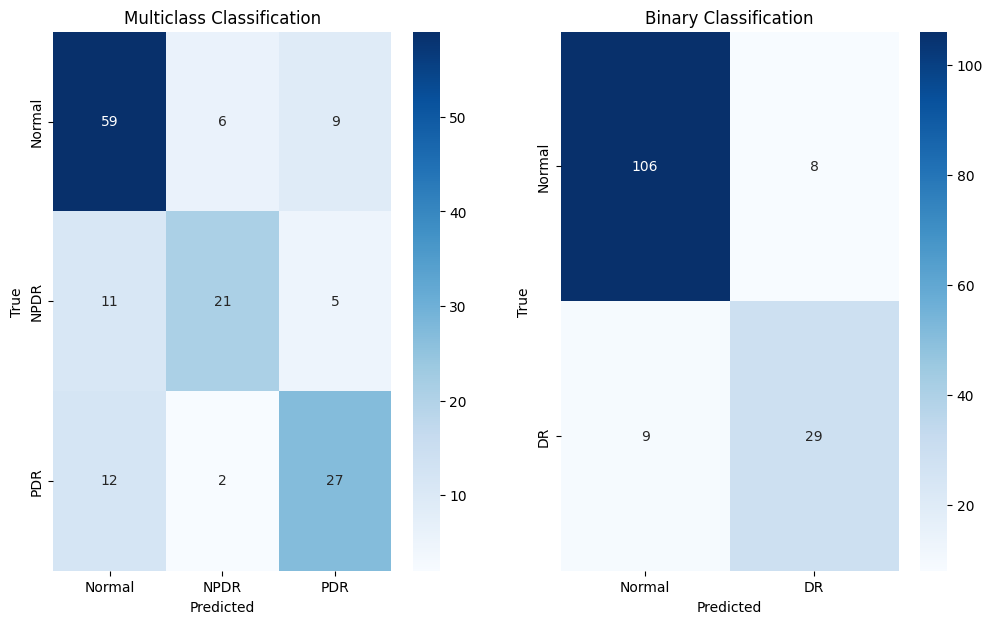

In [99]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
y_pred_bin = clf_bin.predict(X_test_bin)
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
cm
# Define the class labels
class_names = ['Normal', 'NPDR', 'PDR']
ax, fig = plt.subplots(1,2,figsize=(12,7))
plt.subplot(1,2,1)
# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Multiclass Classification')
# Define the class labels
class_names_bin = ['Normal','DR']
plt.subplot(1,2,2)
# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm_bin, annot=True, cmap='Blues', fmt='g', xticklabels=class_names_bin, yticklabels=class_names_bin)
# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Binary Classification')

# Display the plot
plt.show()

### 6.2 Classification Report

#### Binary Classification Report


In [108]:
# Get the predicted labels for the test data
from sklearn.metrics import classification_report
y_pred_bin = clf_bin.predict(X_test_bin)
# Generate a classification report
report = classification_report(y_test_bin, y_pred_bin)
print(report)


              precision    recall  f1-score   support

          DR       0.92      0.93      0.93       114
      Normal       0.78      0.76      0.77        38

    accuracy                           0.89       152
   macro avg       0.85      0.85      0.85       152
weighted avg       0.89      0.89      0.89       152



#### Multiclass Classification Report

In [ ]:
# Get the predicted labels for the test data
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
# Generate a classification report
report = classification_report(y_test, y_pred)
print(report)